# Sequential Group Composition on $C_n \times C_n$

**Group:** Product of cyclic groups $C_n \times C_n$ of order $n^2$.  
**Task:** Given a sequence of $k$ group elements $g_1, \ldots, g_k \in C_n \times C_n$, predict their cumulative product.  
**Sequence length:** $k = 3$ (sequential composition).  
**Architecture:** `QuadraticRNN` with quadratic recurrence.  
**Key result:** The RNN composes elements sequentially in $k$ steps, exploiting associativity.

## Imports

In [1]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import src.dataset as dataset
import src.model as model
import src.optimizer as optimizer
import src.power as power
import src.template as template
import src.train as train_mod
import src.viz as viz

## Configuration

In [2]:
TEST_MODE = os.environ.get("NOTEBOOK_TEST_MODE", "0") == "1"

seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

p1, p2 = 3, 3  # Cn x Cn dimensions
p_flat = p1 * p2
k = 3  # Sequence length
hidden_dim = 50 if TEST_MODE else 200
epochs = 2 if TEST_MODE else 10000
num_samples = 100 if TEST_MODE else 10000
batch_size = 64 if TEST_MODE else 1000
lr = 1e-3
init_scale = 1e-2
mode = "sampled"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

FIGURES_DIR = "figures"
os.makedirs(FIGURES_DIR, exist_ok=True)

print(f"Group: C_{p1} x C_{p2}, order {p_flat}")
print(f"Sequence length: k={k}")
print(f"Device: {device}")

Group: C_3 x C_3, order 9
Sequence length: k=3
Device: cuda


## Template and Dataset

In [3]:
# Build a 2D template with known Fourier structure
tpl_2d = template.unique_freqs_2d(p1, p2, n_freqs=4, seed=seed)

# Build sequential dataset
X, Y, sequence_xy = dataset.build_modular_addition_sequence_dataset_2d(
    p1, p2, tpl_2d, k, mode=mode, num_samples=num_samples,
)

X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
Y_tensor = torch.tensor(Y, dtype=torch.float32).to(device)

ds = TensorDataset(X_tensor, Y_tensor)
dataloader = DataLoader(ds, batch_size=batch_size, shuffle=True)

print(f"Dataset: {len(ds)} samples")
print(f"X shape: {X_tensor.shape} (N, k, p1*p2)")
print(f"Y shape: {Y_tensor.shape} (N, p1*p2)")

Dataset: 10000 samples
X shape: torch.Size([10000, 3, 9]) (N, k, p1*p2)
Y shape: torch.Size([10000, 9]) (N, p1*p2)


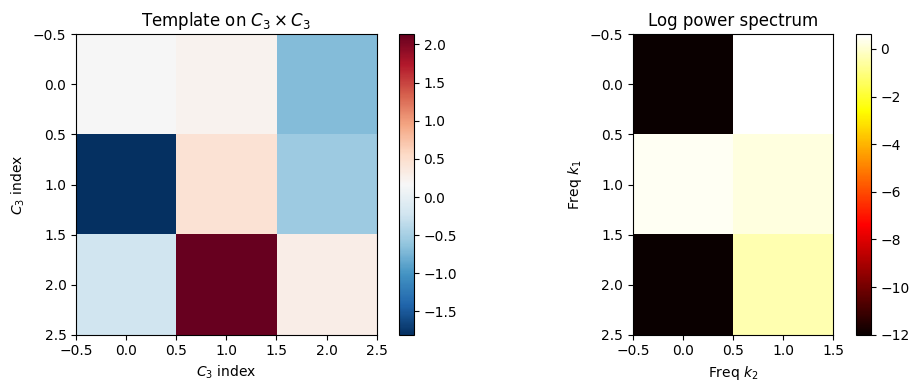

In [4]:
# Visualize template
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

im = ax1.imshow(tpl_2d, cmap="RdBu_r")
ax1.set_title(f"Template on $C_{{{p1}}} \\times C_{{{p2}}}$")
ax1.set_xlabel("$C_{" + str(p2) + "}$ index")
ax1.set_ylabel("$C_{" + str(p1) + "}$ index")
plt.colorbar(im, ax=ax1)

# Show 2D power spectrum
pwr_2d = power.get_power_2d(tpl_2d, no_freq=True)
im2 = ax2.imshow(np.log10(pwr_2d + 1e-12), cmap="hot")
ax2.set_title("Log power spectrum")
ax2.set_xlabel("Freq $k_2$")
ax2.set_ylabel("Freq $k_1$")
plt.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.savefig(f"{FIGURES_DIR}/sequential_cnxcn_template.pdf", bbox_inches="tight")
plt.show()

## Model and Optimizer

In [5]:
net = model.QuadraticRNN(
    p=p_flat,
    d=hidden_dim,
    template=tpl_2d.flatten(),
    init_scale=init_scale,
)
net = net.to(device)

criterion = nn.MSELoss()
opt = optimizer.HybridRNNOptimizer(net, lr=lr)

print(f"Model: QuadraticRNN(p={p_flat}, d={hidden_dim}, k={k})")
print(f"Optimizer: HybridRNNOptimizer(lr={lr})")
print(f"Training for {epochs} epochs")

Model: QuadraticRNN(p=9, d=200, k=3)
Optimizer: HybridRNNOptimizer(lr=0.001)
Training for 10000 epochs


## Training

In [6]:
loss_history, val_loss_history, param_history, param_save_epochs, final_epoch = train_mod.train(
    net,
    dataloader,
    criterion,
    opt,
    epochs=epochs,
    verbose_interval=500,
    save_param_interval=100,
)

[Epoch   500/10000] loss: 0.999998 | reduction:    0.0%
[Epoch  1000/10000] loss: 0.545301 | reduction:   45.5%
[Epoch  1500/10000] loss: 0.447867 | reduction:   55.2%
[Epoch  2000/10000] loss: 0.224957 | reduction:   77.5%
[Epoch  2500/10000] loss: 0.224072 | reduction:   77.6%
[Epoch  3000/10000] loss: 0.223029 | reduction:   77.7%
[Epoch  3500/10000] loss: 0.139860 | reduction:   86.0%
[Epoch  4000/10000] loss: 0.045278 | reduction:   95.5%
[Epoch  4500/10000] loss: 0.044631 | reduction:   95.5%
[Epoch  5000/10000] loss: 0.044368 | reduction:   95.6%
[Epoch  5500/10000] loss: 0.044295 | reduction:   95.6%
[Epoch  6000/10000] loss: 0.044125 | reduction:   95.6%
[Epoch  6500/10000] loss: 0.044009 | reduction:   95.6%
[Epoch  7000/10000] loss: 0.043914 | reduction:   95.6%
[Epoch  7500/10000] loss: 0.043868 | reduction:   95.6%
[Epoch  8000/10000] loss: 0.043768 | reduction:   95.6%
[Epoch  8500/10000] loss: 0.043734 | reduction:   95.6%
[Epoch  9000/10000] loss: 0.043649 | reduction: 

## Training Loss

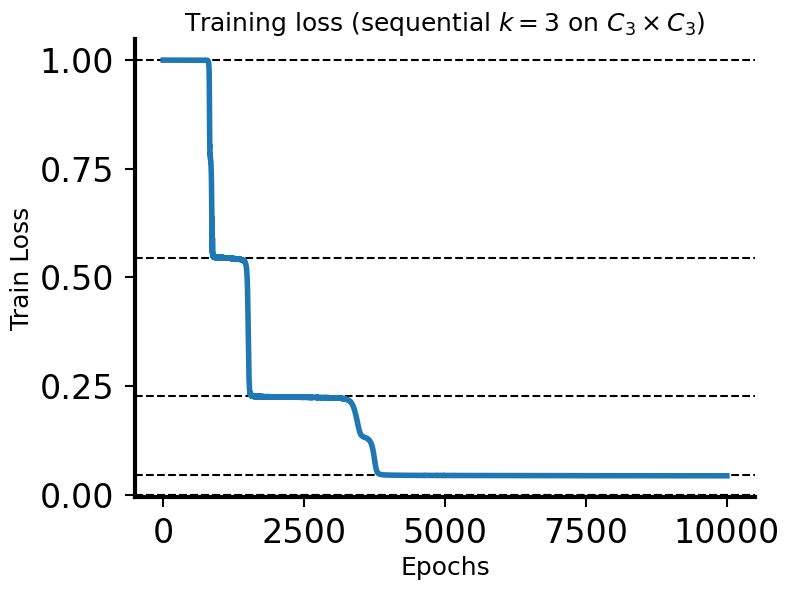

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot training loss with theoretical levels
ax.plot(loss_history, lw=4, label="Train loss")

theory = power.theoretical_loss_levels_2d(tpl_2d)
for level in theory["levels"]:
    ax.axhline(y=level, color="black", linestyle="--", linewidth=1.5, zorder=-2)

ax.set_xlabel("Epochs", fontsize=18)
ax.set_ylabel("Train Loss", fontsize=18)
ax.set_title(f"Training loss (sequential $k={k}$ on $C_{{{p1}}} \\times C_{{{p2}}}$)", fontsize=18)
viz.style_axes(ax)
ax.grid(False)

plt.tight_layout()
plt.savefig(f"{FIGURES_DIR}/sequential_cnxcn_loss.pdf", bbox_inches="tight")
plt.show()

## Predictions

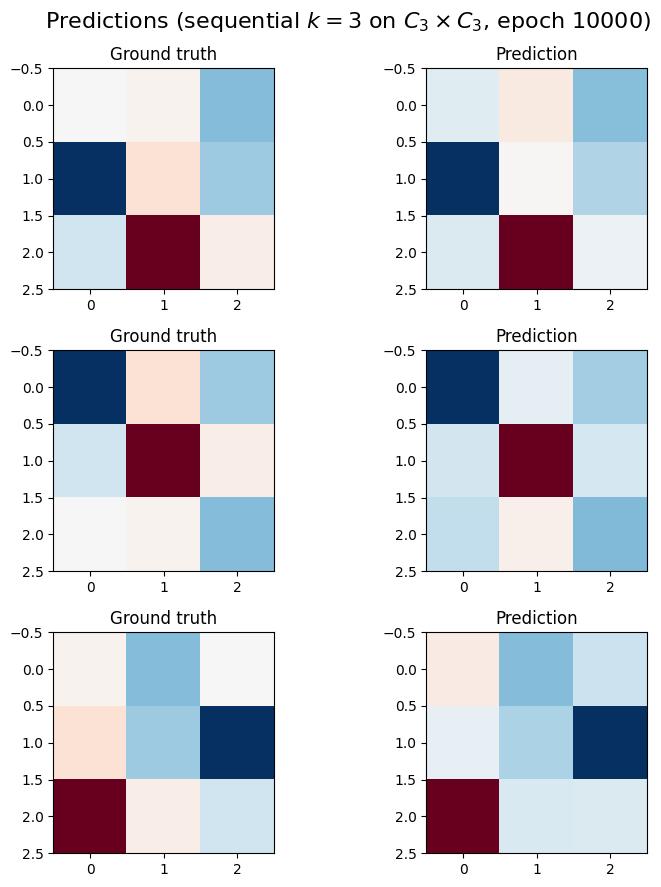

In [8]:
# Show predictions vs ground truth
net.load_state_dict(param_history[-1])
net.eval()

n_examples = 3
indices = np.random.choice(len(Y_tensor), size=n_examples, replace=False)

fig, axes = plt.subplots(n_examples, 2, figsize=(8, 3 * n_examples))

with torch.no_grad():
    x_batch = X_tensor[indices]
    preds = net(x_batch).detach().cpu().numpy()
    truths = Y_tensor[indices].detach().cpu().numpy()

for i in range(n_examples):
    axes[i, 0].imshow(truths[i].reshape(p1, p2), cmap="RdBu_r")
    axes[i, 0].set_title("Ground truth")
    axes[i, 1].imshow(preds[i].reshape(p1, p2), cmap="RdBu_r")
    axes[i, 1].set_title("Prediction")

plt.suptitle(f"Predictions (sequential $k={k}$ on $C_{{{p1}}} \\times C_{{{p2}}}$, epoch {final_epoch})", fontsize=16)
plt.tight_layout()
plt.savefig(f"{FIGURES_DIR}/sequential_cnxcn_predictions.pdf", bbox_inches="tight")
plt.show()